# To determine what features will best predict cpu/event

we'll calculate averages of cpu/event per CPU and processing type and use that dummy predictor
we'll fit separately fastBmk, bogomips, hs06, whetstone to cpu/event for each processing type adn use that as a predictor

compare all 5.


In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score


### Get datasets

In [18]:
jobs = pd.DataFrame()
input_files=['job_2017-04.csv','job_2017-05.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file).set_index('pandaid'))
jobs = pd.concat(tmp)

jobs = jobs[jobs['nevents']>20]
jobs = jobs[jobs['inputsize']>1024]

del jobs['cputime']
del jobs['walltime']
del jobs['nevents']
del jobs['cpueff']
del jobs['wallPerEvent']
del jobs['inputsize']

jobs.head()

,hs06,processingtype,cpuPerEvent
pandaid,,,
3352703758,107,recon,4.436667
3354732793,10,evgen,1.100000
3326375042,96,reprocessing,12.623182
3327803396,77,merge,0.358200
3330689156,90,merge,0.337855


In [19]:
input_files=['benchmark_2017-04.csv','benchmark_2017-05.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file).set_index('pandaid'))
benchmarks = pd.concat(tmp)

print(benchmarks.columns)

del benchmarks['ip']
del benchmarks['site']
del benchmarks['meminfo']

print(benchmarks.columns)

benchmarks.head()

Index(['bogomips', 'ip', 'site', 'mpnum', 'cpuname', 'meminfo', 'fastBmk',
       'whetstone'],
      dtype='object')
Index(['bogomips', 'mpnum', 'cpuname', 'fastBmk', 'whetstone'], dtype='object')


,bogomips,mpnum,cpuname,fastBmk,whetstone
pandaid,,,,,
3322806223,5333.52,1,QEMU Virtual CPU version (cpu64-rhel6),9.223674,3195.99
3322633663,5000.00,1,Intel(R) Xeon(R) CPU E5420 @ 2.50GHz,12.129380,2749.34
3322488785,4988.06,1,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,23.731048,3599.70
3322806277,5333.16,1,Intel(R) Xeon(R) CPU X5650 @ 2.67GHz,12.240734,3426.18
3322875248,5332.58,1,Intel(R) Xeon(R) CPU E5430 @ 2.66GHz,12.349914,2911.33


### join dataframes and filter out bad rows

In [20]:
benchmarks = benchmarks.join(jobs,how='inner')
#benchmarks = benchmarks[benchmarks.cpuPerMB > 0]
#benchmarks = benchmarks[benchmarks.cpuPerEvent > 0]
benchmarks = benchmarks[benchmarks.mpnum == 1]

del benchmarks['mpnum']

benchmarks.head(20)

,bogomips,cpuname,fastBmk,whetstone,hs06,processingtype,cpuPerEvent
pandaid,,,,,,,
3323737831,5199.28,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.863749,3612.79,10,simul,73.644
3323782011,5199.25,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.869888,3628.96,10,evgen,154.110
3323782017,4189.98,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,18.136020,3306.22,10,evgen,159.280
3323788151,5199.24,Intel(R) Xeon(R) CPU E5-2640 v3 @ 2.60GHz,20.642202,3495.29,10,evgen,167.210
3323820043,4787.82,Intel(R) Xeon(R) CPU E5620 @ 2.40GHz,6.792453,1532.55,13,evgen,426.825
3323843154,5199.25,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,12.653779,3556.37,10,evgen,263.360
3323854999,4999.17,Intel(R) Core(TM)2 Quad CPU Q8300 @ 2.50GHz,11.214953,2777.86,11,evgen,458.715
3323855148,4999.27,Intel(R) Xeon(R) CPU E5-2609 v2 @ 2.50GHz,12.977650,3002.83,11,evgen,263.035
3323861954,4189.99,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,14.729951,3150.31,10,evgen,314.350


### split over different processing types 

In [21]:
UniqueProcessingTypes = benchmarks.processingtype.unique()
print(UniqueProcessingTypes)
UniqueProcessingTypes=UniqueProcessingTypes.tolist()

UniqueProcessingTypes.remove('overlay')
UniqueProcessingTypes.remove('deriv')

#create a dict for all the dataframes to be filled later
ProcessingType = {elem : pd.DataFrame for elem in UniqueProcessingTypes}


#filling up data frames
for key in ProcessingType.keys():
    ProcessingType[key] = benchmarks[:][benchmarks.processingtype == key]

    

['simul' 'evgen' 'reprocessing' 'merge' 'recon' 'pmerge' 'pile' 'overlay'
 'deriv']


### plot correlations

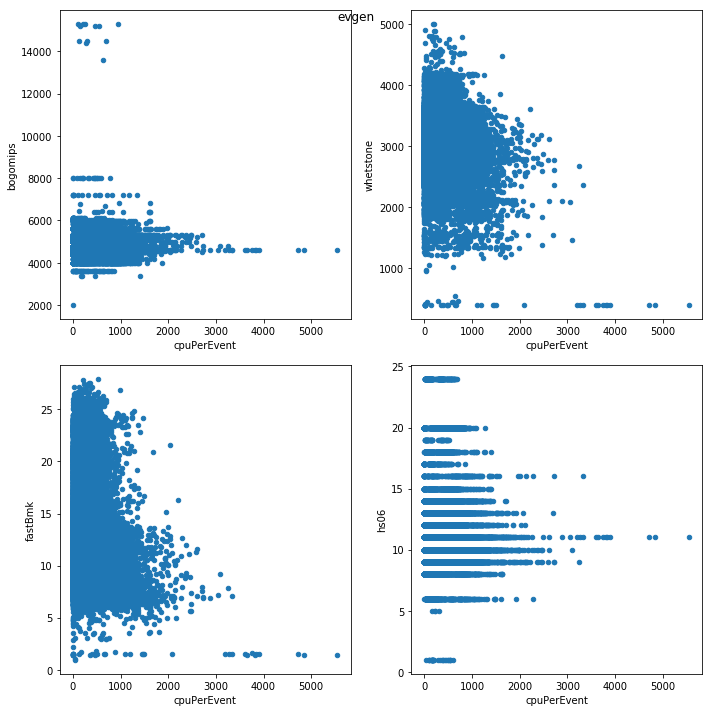

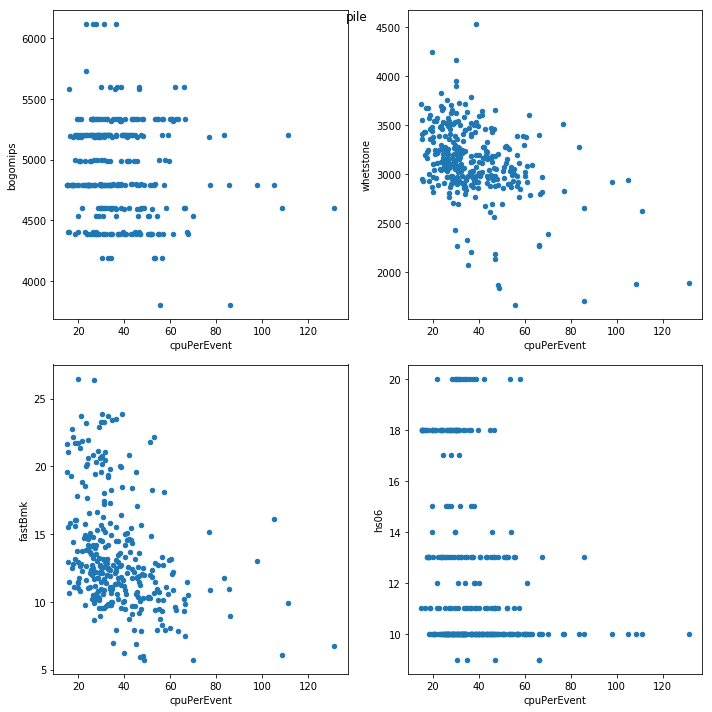

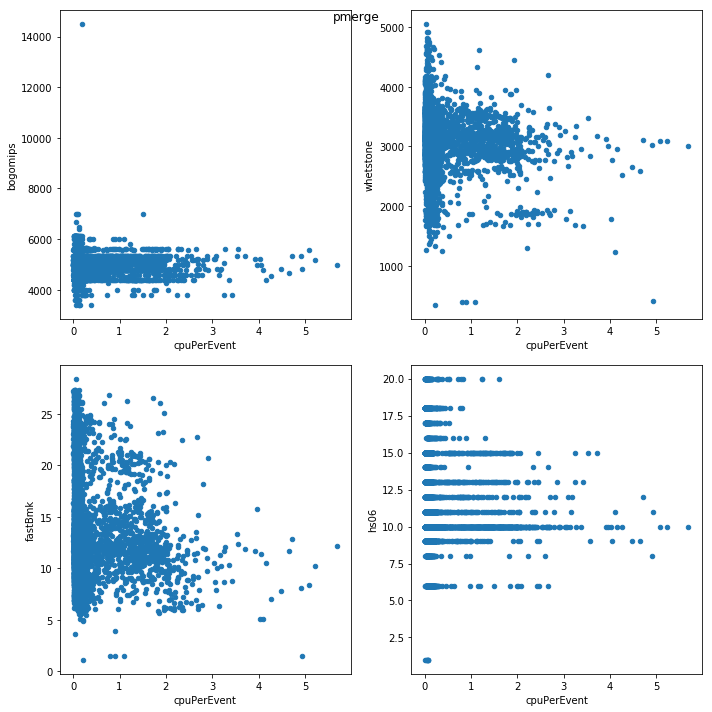

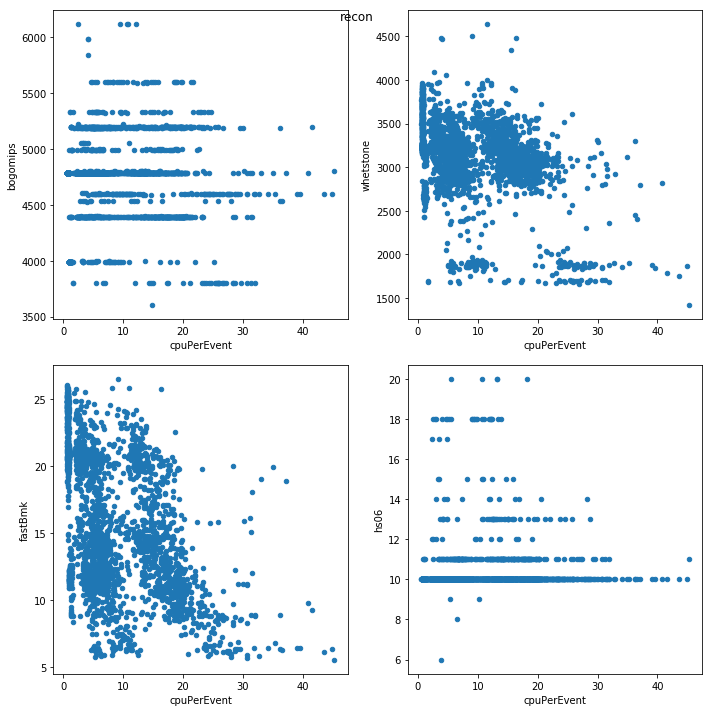

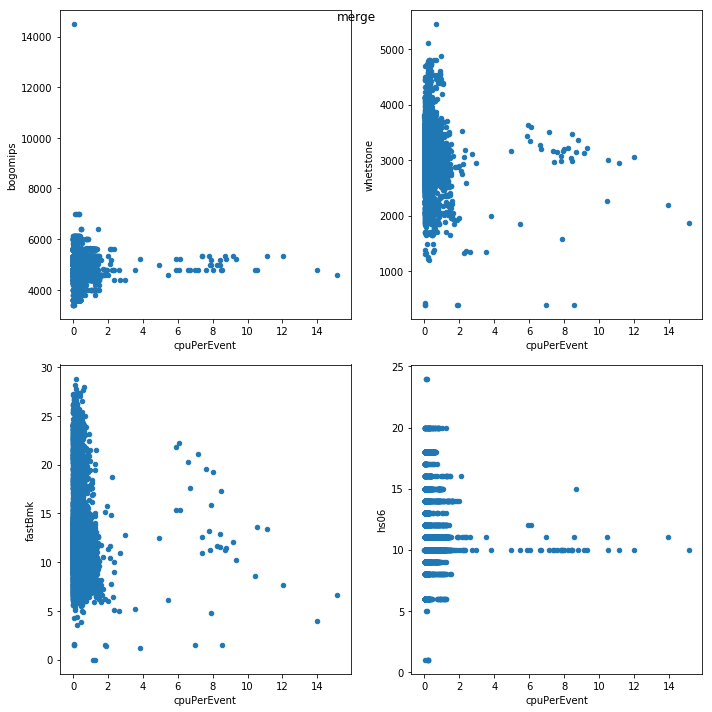

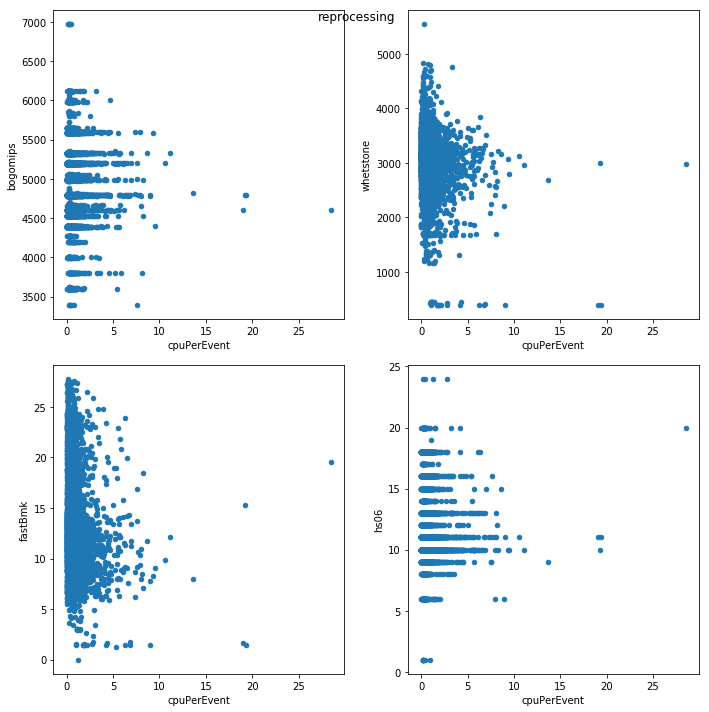

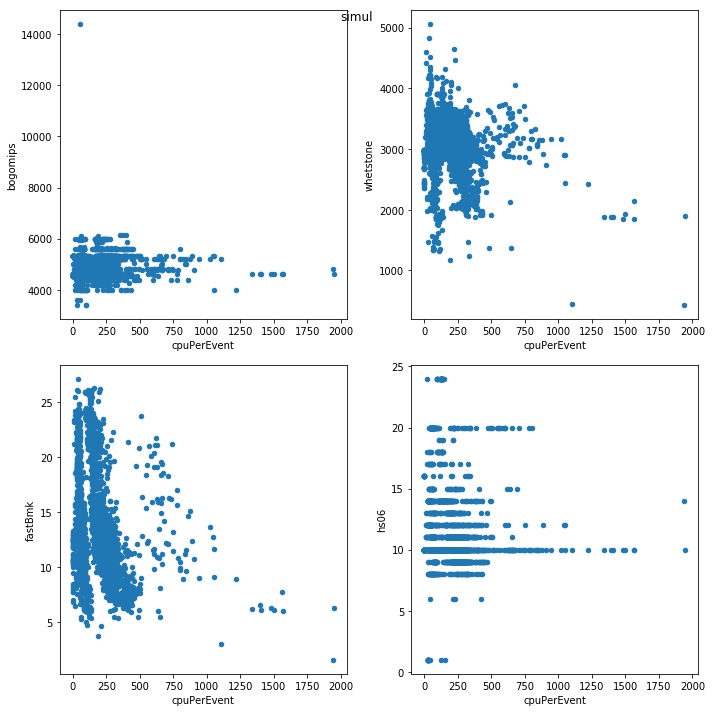

In [22]:
feat = ['bogomips', 'fastBmk', 'whetstone', 'hs06']
for pt in ProcessingType.keys():
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(10,10)
    plt.suptitle(pt)
    data = ProcessingType[pt]
    for nf, f in enumerate(feat):
        i = nf%2
        j = int(nf/2)
        data.plot(ax=axes[i,j], x="cpuPerEvent", y=f, kind='scatter') 
#         axes[i,j].hist2d(x=data["cpuPerEvent"], y=data[f], bins=30)#, norm=LogNorm())
#         axes[i,j].colorbar()
    fig.tight_layout()

### split on training and testing samples

===========  evgen =============
(21203, 5) (21203, 1) (5301, 5) (5301, 1)
***  bogomips  ***
cross validation score:  283.893808013
	evs: 0.0005 	mae:   273.8643 	mse: 122706.9366 	r2:    0.0005
***  fastBmk  ***
cross validation score:  279.331588246
	evs: 0.0578 	mae:   269.8301 	mse: 115669.0304 	r2:    0.0578
***  whetstone  ***
cross validation score:  281.197045125
	evs: 0.0622 	mae:   270.8447 	mse: 115128.2520 	r2:    0.0622
***  hs06  ***
cross validation score:  284.793925782
	evs: 0.0006 	mae:   274.1002 	mse: 122685.0545 	r2:    0.0006
     bogomips     fastBmk        hs06   whetstone
0 -685.947180 -653.988927 -687.769027 -658.940321
1  100.702558 -113.810612   71.511713  -38.887292
2 -763.244127 -659.288561 -770.051578 -600.325693
3  348.909782  371.980542  352.871697  372.477634
4 -572.090349 -472.842903 -556.751578 -455.932044
Describe predictions
             actual     bogomips      fastBmk         hs06    whetstone
count  5301.000000  5301.000000  5301.000000  5301.0

     actual  bogomips   fastBmk      hs06  whetstone
0  0.469772  0.294970  0.326519  0.303920   0.319119
1  0.181433  0.294984  0.320515  0.342615   0.291532
2  0.440100  0.283968  0.342605  0.294246   0.349428
3  0.185600  0.300384  0.221596  0.303920   0.273999
4  0.007400  0.287588  0.294801  0.303920   0.304021
(5386, 2) (1347, 2)
---------------------------------------
===========  reprocessing =============
(7332, 5) (7332, 1) (1834, 5) (1834, 1)
***  bogomips  ***
cross validation score:  0.479174708123
	evs: -0.0018 	mae:     0.4594 	mse:     0.6356 	r2:   -0.0020
***  fastBmk  ***
cross validation score:  0.470236082324
	evs: 0.0170 	mae:     0.4502 	mse:     0.6237 	r2:    0.0168
***  whetstone  ***
cross validation score:  0.470717637926
	evs: 0.0297 	mae:     0.4514 	mse:     0.6157 	r2:    0.0293
***  hs06  ***
cross validation score:  0.479588008314
	evs: -0.0010 	mae:     0.4591 	mse:     0.6351 	r2:   -0.0011
   bogomips   fastBmk      hs06  whetstone
0 -0.483810 -0.71

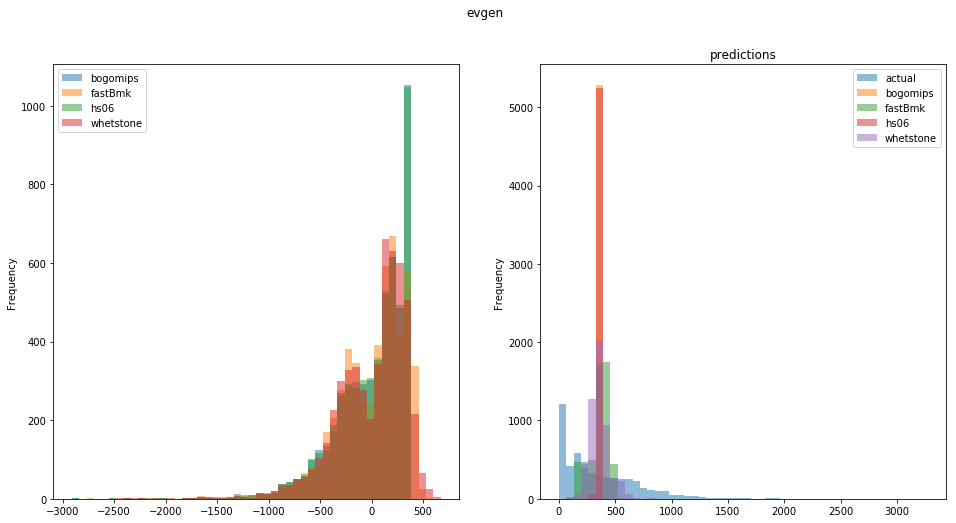

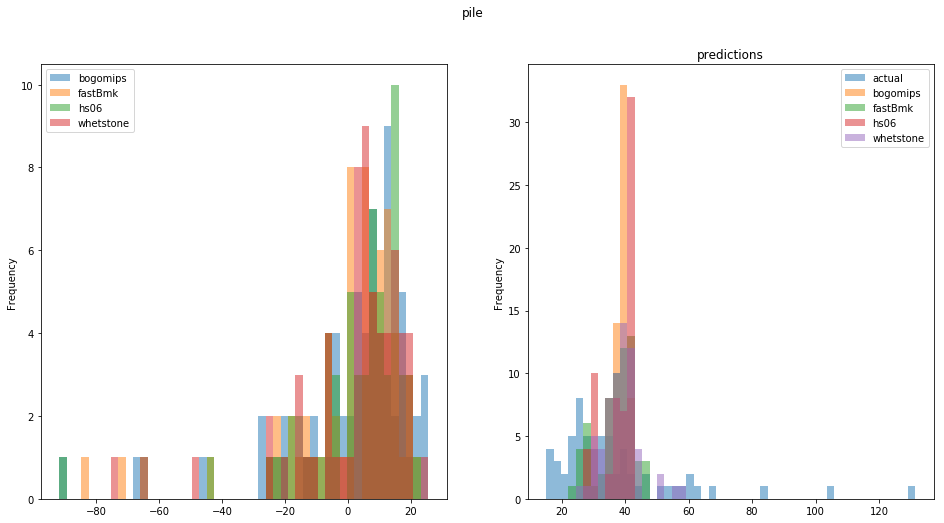

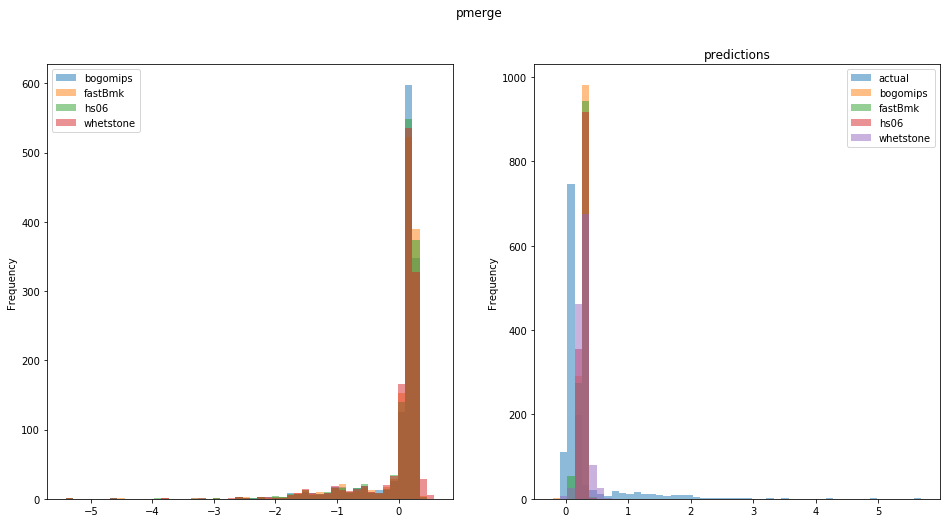

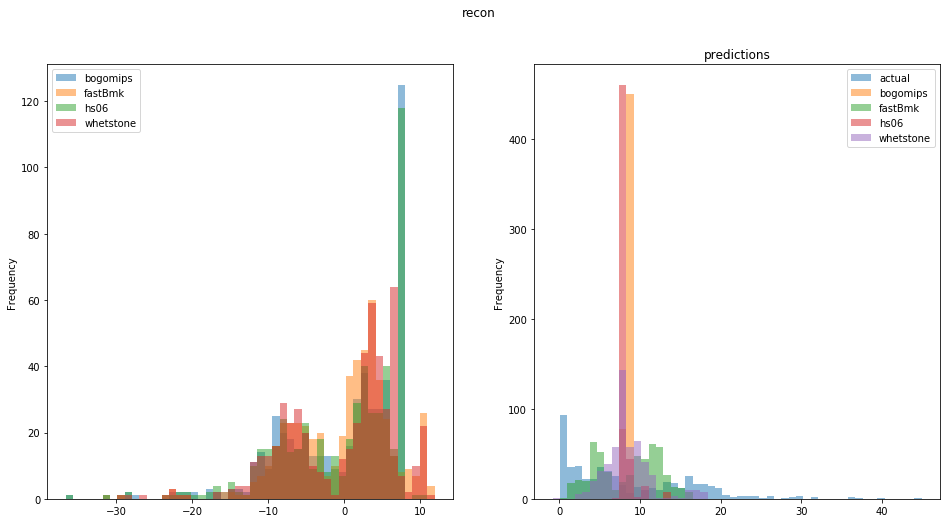

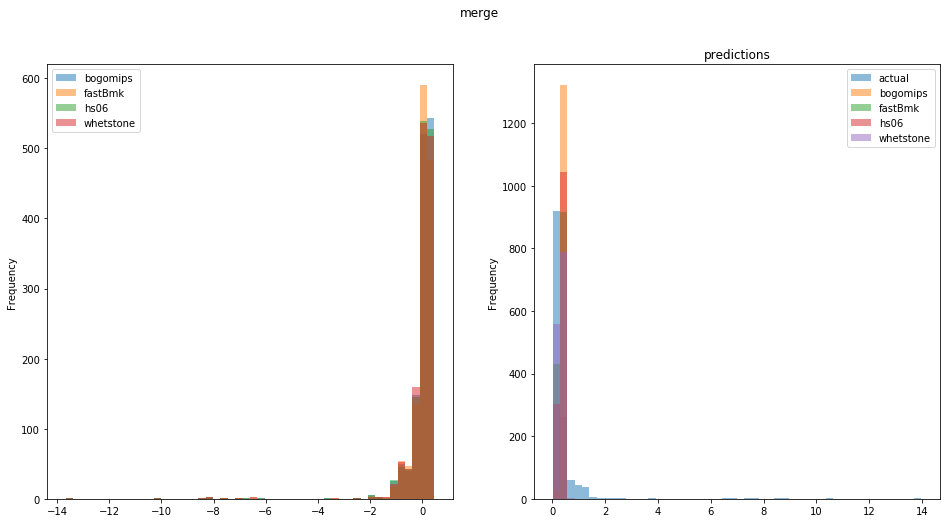

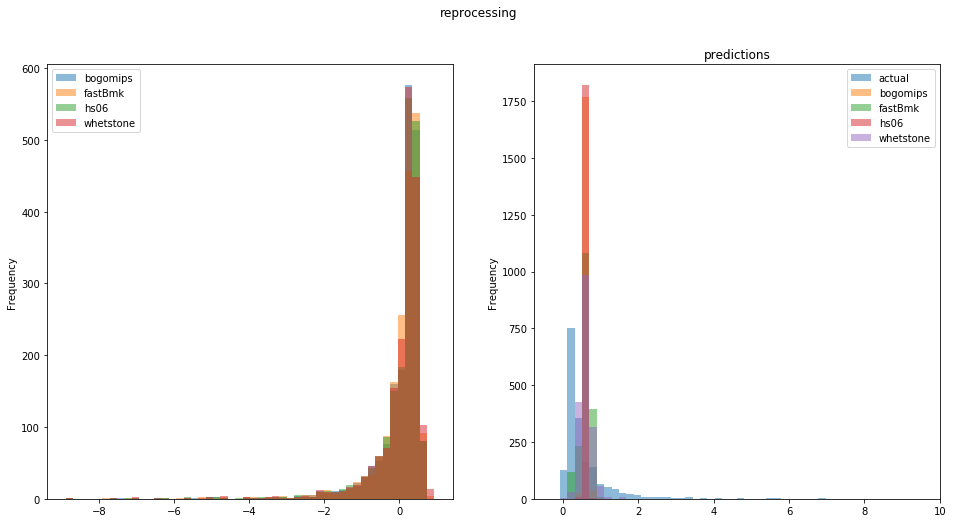

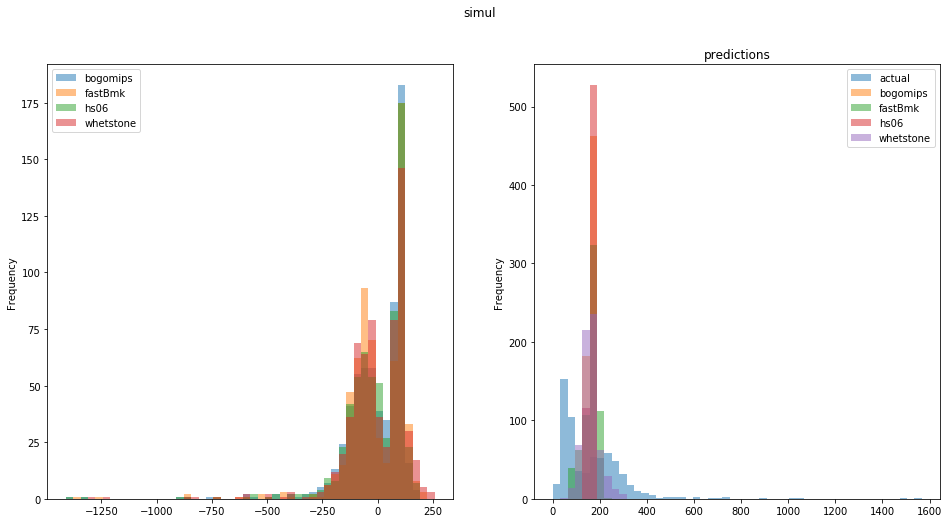

In [23]:
R_mse = {}
R_r2  = {}

#####  LRs ####
lr = LinearRegression()

for pt in ProcessingType:
    print("=========== ",pt,"=============")
    data = ProcessingType[pt]
    tmse=[]
    tr2=[]
    #target
    y = data['cpuPerEvent'].copy()
    y = y.values.reshape(-1, 1)
    #print(data['cpuPerEvent'].describe())
    
    X=data.copy()
    del X['cpuPerEvent']
    del X['processingtype']
    #print(X.columns)

    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=41)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    predictions={'actual':y_test.flatten()}
    errors = {}
    
    for f in feat:
        print( "*** ",f," ***")
        lr = LinearRegression()
        # to do cross validation 
        scores = cross_val_score(lr, X[f].values.reshape(-1,1), y, cv=10, scoring='neg_mean_absolute_error')
        #  [ 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 
        #   'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error',  
        #   'precision_macro', 'precision_micro', 'precision_samples', 'r2', 
        #   'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc']
        print("cross validation score: ", -scores.mean())
        
        lm = lr.fit(X_train[f].values.reshape(-1,1), y_train)
        #print ("Linear model:",lm.coef_ , lm.intercept_)
        #hold-out testing
        y_test_predict = lm.predict(X_test[f].values.reshape(-1,1))
        
        errors[f] = (y_test_predict-y_test).flatten().tolist()
        predictions[f] = y_test_predict.flatten().tolist()
        
        evs = explained_variance_score(y_test, y_test_predict)
        mae = mean_absolute_error(y_test, y_test_predict)
        mse = mean_squared_error(y_test, y_test_predict)
        r2 = r2_score(y_test, y_test_predict) 
        print("\tevs: %2.4f" % evs, "\tmae: {:>10.4f}".format(mae), "\tmse: {:>10.4f}".format(mse), "\tr2:{:>10.4f}".format(r2)) 
        tmse.append(mae)
        tr2.append(r2)
        #print("---------------------------------------")
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plt.suptitle(pt)
    plt.title("errors")
    pl = pd.DataFrame(errors)
    #print("Describe residuals\n", pl.describe())
    pl.plot(ax=axes[0], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
    print(pl.head(5))
    pl = pd.DataFrame(predictions)
    plt.title("predictions")
    print("Describe predictions\n", pl.describe())
    pl.plot(ax=axes[1], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
    print(pl.head(5))
    ###  based on CPU
    cdata = data.copy()
    del cdata['processingtype']
    del cdata['bogomips']
    del cdata['fastBmk']
    del cdata['whetstone']
    del cdata['hs06']

    cdata_train, cdata_test =  train_test_split( cdata, test_size=0.20, random_state=41)
    print(cdata_train.shape, cdata_test.shape)

    predictions_on_CPU = cdata_train.groupby('cpuname').mean()
    #print(predictions_on_CPU)

    res=[]
    pre=[]
    not_used=0
    for index, row in cdata_test.iterrows():
        cn  = row['cpuname']
        cpe = row['cpuPerEvent']
        if cn in predictions_on_CPU.index:
            res.append(cpe)
            pre.append(predictions_on_CPU.loc[cn,'cpuPerEvent'])
        else:
            not_used += 1 

    #print(not_used,' test results had CPU not seen in training data.')
        
    #for i in range(len(res)):
    #    print(res[i], pre[i])
    comp=pd.DataFrame({'res':res,'pre':pre})
    #comp

    evs = explained_variance_score(comp.res, comp.pre)
    mae = mean_absolute_error(comp.res, comp.pre)
    mse = mean_squared_error(comp.res, comp.pre)
    r2 = r2_score(comp.res, comp.pre) 
    #print( "%2.4f" % evs, "{:>10.4f}".format(mae), "{:>10.4f}".format(mse), "{:>10.4f}".format(r2)) 
    tmse.append(mae)
    tr2.append(r2)
    R_mse[pt]=tmse
    R_r2[pt]=tr2
    print("---------------------------------------")
        
#print(R_r2)

### plot results

In [24]:
Results=pd.DataFrame(R_r2,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,pile,pmerge,recon,reprocessing,simul
bogomips,0.000459,-0.001716,-0.012861,-0.000550,-0.002287,-0.002007,-0.001070
fastBmk,0.057788,0.012722,0.132075,0.011636,0.274858,0.016796,0.036952
whetstone,0.062193,0.014004,0.192779,0.007979,0.110432,0.029345,0.034731
hs06,0.000637,-0.000817,0.100729,0.004580,0.011103,-0.001097,0.003289
cpu name,0.068669,0.011368,0.235483,0.036172,0.338703,-0.020143,0.172343


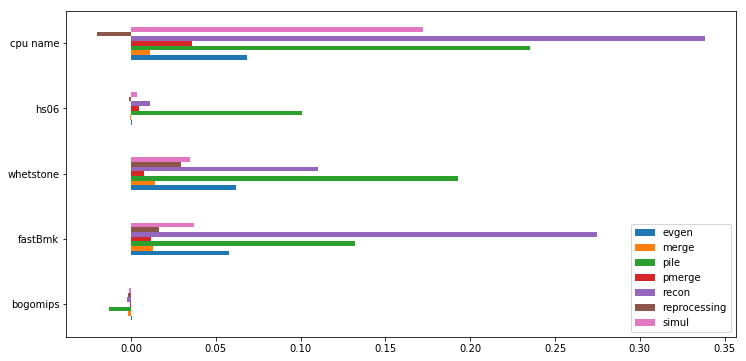

In [25]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks_r2.png")

In [26]:
Results=pd.DataFrame(R_mse,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,pile,pmerge,recon,reprocessing,simul
bogomips,273.864299,0.289286,14.344742,0.307254,6.400065,0.459391,102.795458
fastBmk,269.830120,0.284209,12.801837,0.306892,5.245751,0.450173,102.520491
whetstone,270.844728,0.286831,13.102929,0.306460,6.157125,0.451422,102.360579
hs06,274.100245,0.288162,13.487037,0.306287,6.317673,0.459145,102.479641
cpu name,264.755182,0.276901,13.118328,0.297932,4.762792,0.456517,84.055861


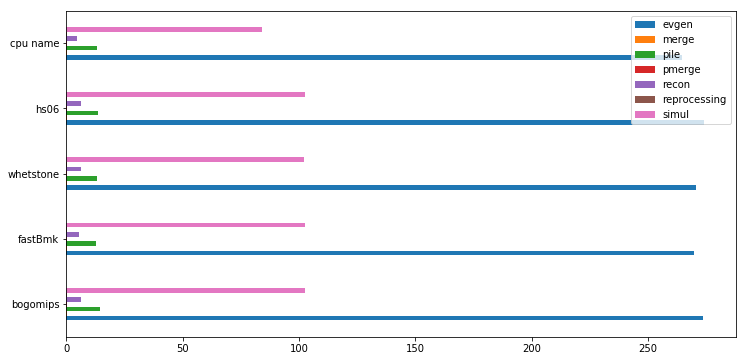

In [27]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks_mse.png")